In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [2]:
import ranking_funcs

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from ranking_funcs import Comp_Greedy_Algo_backdoor,get_prob_backdoor_opt,rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

In [4]:
df=read_data('German.csv')

installment_plans
number_of_credits
employment
housing
credit_history
skill_level


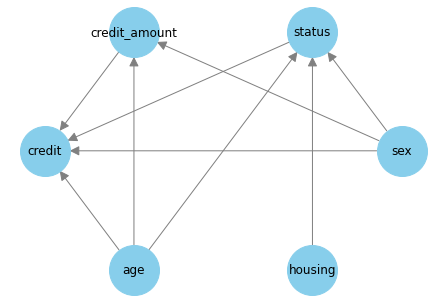

In [5]:
G = nx.DiGraph()


nodes = ['sex', 'status', 'credit_amount', 'credit', 'age', 'housing']
G.add_nodes_from(nodes)

G.add_edges_from([('sex', 'status'), ('sex', 'credit_amount'), ('sex', 'credit'),
                  ('housing', 'status'), ('age', 'status'), 
                  ('age', 'credit'), ('age', 'credit_amount'),('credit_amount', 'credit'),('status', 'credit')])


layout = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)

plt.savefig(f'ranking_plots/causal_graph_German.png')
plt.show()

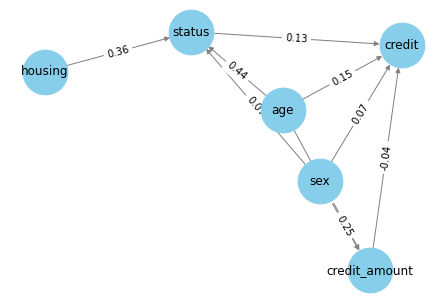

In [6]:
new_G=get_new_G(G,df)
pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()

In [43]:
ranks=get_ranking_query(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
5,3,1.0,1.046003,1,3,0,2.0,5.0,1.0,1,...,2.0,3.0,0.0,2.0,2.0,1.0,0,3.359667,0.0,2
1,3,0.0,0.000000,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.000000,2.0,0
7,3,1.0,1.046003,1,3,0,2.0,2.0,1.0,1,...,2.0,2.0,0.0,2.0,1.0,1.0,0,1.359667,3.0,0
3,3,1.0,1.046003,1,3,0,3.0,3.0,1.0,1,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.359667,2.0,0
17,3,0.0,1.000000,0,3,1,0.0,5.0,1.0,1,...,0.0,2.0,0.0,2.0,1.0,0.0,0,0.000000,2.0,2


### Simulating the ranking probility

In [ ]:
base_line(df,5)

#### Backdoor adjustment probs

### Greedy algorithm

In [13]:
var=['sex', 'status', 'credit', 'age', 'housing']

In [14]:
df_gr=Greedy_Algo(new_G, df, 5, 'credit_amount',var,0, {'age':1},100, opt="add",force=0.5)

In [15]:
df_gr

,rank,prob,total_iters
0,"[5, 18, 7, 3, 29]",0.204,102.0
1,"[5, 7, 18, 3, 29]",0.098,49.0
2,"[7, 5, 18, 3, 29]",0.098,49.0
3,"[5, 1, 7, 3, 17]",0.600,300.0


In [16]:
most_probable_elements=get_most_probable_elements(df_gr)
most_probable_elements

,element,prob,total_iters
0,3,1.0,500.0
1,5,1.0,500.0
2,7,1.0,500.0
3,18,0.4,200.0
4,29,0.4,200.0
5,1,0.6,300.0
6,17,0.6,300.0


### Calculate the Pr(r1>=theta1,r5>=theta1,r7>=theta1|given updates)

In [95]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference.CausalInference import CausalInference

def find_backdoor_sets_opt(G, Y, X):
    new_G = BayesianNetwork()
    new_G.add_nodes_from(G.nodes)
    new_G.add_edges_from(G.edges)
    inference = CausalInference(new_G)
    backdoor_sets = inference.get_all_backdoor_adjustment_sets(X, Y)
    if backdoor_sets:
        min_length = min(len(s) for s in backdoor_sets)
        shortest_backdoor_sets = [s for s in backdoor_sets if len(s) == min_length]
        return shortest_backdoor_sets
    else:
        return None




def backdoor_adjustment_opt(df, Y, y, A, a, Z):
    prob = 0
    total_len = len(df)
    total_relevant_Z = 0  

    unique_Z_combinations = df[Z].drop_duplicates()
    for z_values in unique_Z_combinations.itertuples(index=False):
        mask_Z = np.ones(len(df), dtype=bool)
        for column, value in zip(Z, z_values):
            mask_Z = mask_Z & (df[column] == value)
        
        df_Z = df[mask_Z]
        df_A_a_Z = df_Z[df_Z[A] == a]

        if not df_A_a_Z.empty:
            p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
            p_Z = len(df_Z) / total_len
            total_relevant_Z += len(df_Z)
            prob += p_Y_given_A_Z * p_Z
    if total_relevant_Z > 0:
        prob = prob * total_len / total_relevant_Z

    return prob



def get_prob_backdoor_opt(G, df, k, update_vars, target_column, condition, opt, row_indexes, theta):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        dom_y = updated_df[target_column].unique()
        dom_node = updated_df[node].unique()
        for d_y in dom_y:
            for d_n in dom_node:
                adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                results.append({
                    'Y': target_column, 
                    'Y_value': d_y, 
                    'X': node, 
                    'X_value': d_n, 
                    'Z': ', '.join(bd_set), 
                    'prob': adjusted_prob
                })
        prob_df = pd.DataFrame(results)

        total_prob = None
        backdoor_path = None
        for row_index in row_indexes:
            row = updated_df.iloc[row_index]                    
            prob_groups = []
            Z_groups = []
            for z in prob_df['Z'].unique():
                z_relevant_probs = prob_df[
                    (prob_df['Z'] == z) & 
                    (prob_df['Y'] == target_column) & 
                    (prob_df['Y_value'] >= theta)]
                Z_groups.append(z)
                prob_sum = 0
                for x in prob_df['X'].unique():
                    if x in row.index:  
                        x_value = row[x]
                        prob_sum += z_relevant_probs[
                            (z_relevant_probs['X'] == x) & 
                            (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
                prob_groups.append(prob_sum)

            row_prob_df = pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})
            row_total_prob = row_prob_df['prob'].astype(float).to_numpy()

            if total_prob is None:
                total_prob = row_total_prob
            else:
                total_prob *= row_total_prob
            backdoor_path = row_prob_df['backdoor_path'].to_list()

        if total_prob is None:
            return pd.DataFrame()
        final_df = pd.DataFrame({'prob': total_prob, 'backdoor_path': backdoor_path})

    return final_df['prob']

```latex

Algorithm: find_backdoor_sets_opt
Input: Graph G, Target Variable Y, Treatment Variable X
Output: Backdoor Sets

1. Initialize new_G as a BayesianNetwork
2. Add nodes from G to new_G
3. Add edges from G to new_G
4. Perform causal inference on new_G
5. Find all backdoor adjustment sets for X and Y
6. Return the backdoor sets



Algorithm: backdoor_adjustment_opt
Input: Dataframe df, Outcome Variable Y, Outcome Value y, Treatment A, Treatment Value a, Covariates Z
Output: Adjusted Probability

1. Initialize probability to 0
2. Calculate the total number of entries in df
3. Initialize total relevant Z to 0
4. Iterate over unique combinations of Z values
5. For each combination, filter df based on Z values
6. Further filter df for instances where A equals a
7. If filtered dataframe is not empty:
   a. Calculate the conditional probability of Y given A and Z
   b. Calculate the probability of the Z combination
   c. Update the probability sum
8. Adjust the final probability based on total relevant Z
9. Return the adjusted probability




Algorithm: get_prob_backdoor_opt
Input: Graph G, Dataframe df, Parameters k, update_vars, target_column, condition, opt, row_indexes, theta
Output: Probability Sum

1. Update df based on ranking query parameters
2. Initialize an empty list for results
3. For each node in update_vars:
   a. Find backdoor sets for the node and target_column
   b. Iterate over backdoor sets and domain values of Y and node
   c. Calculate adjusted probability for each combination
   d. Append results with calculated probabilities
4. Convert results to a dataframe
5. Initialize variables for total probability and backdoor path
6. For each row index:
   a. Calculate the probability sum for each backdoor path
   b. Update the total probability and backdoor path
7. If total probability is not None:
   a. Calculate the final probability sum
8. Return the final probability sum

```


In [87]:
get_prob_backdoor_opt(new_G, df, len(df), {'credit_amount':4}, 'credit',{'age':1},'add',[0,4,6],-np.inf)
## I can just the small one

- step1 for each back door set we have$\sum_{i=1}^{n}Pr(Y=y|X=x,Z=z_i)Pr(Z=z_i)$
- step 2 we calculate $\sum_{j=1}^{n}Pr(Y=y_i|X=x,Z)$ with $y_i \geq \theta$, 
- step 3 we calculate $\prod_{k=1}^{n}Pr(Y=y_1,y_2 ...|X=x_k)$ with $x_k$ is in the input r, 3 is not needed
- step 4 we multiply the $\prod_{L=1}^{n}Pr(Y=y_1,y_2 ...|X=x_1,x_2..., r_L)$ to get the Pr(r1>=theta1,r5>=theta1,r7>=theta1|given updates) for each backdoor path

In [ ]:
Pr(a=1,2,3 |x=2,h=3,q=2)

In [ ]:
Pr(a=1|x=2,age)
Pr(a=1,2,3|x=2,age) if a >= theta
Pr(a=1,2,3|h=3,age) if a >= theta
Pr(a=1,2,3|q=2,age) if a >= theta

prod()
if we have row index 1 with x=2,h=3,q=2

### X should be the intervention X

$\sum Pr(top k |backdoor) Pr(backdoor)$

$Pr(backdoor)$ is missing

- We have n backdoor paths, the backdoor prob is $\frac{1}{n}$

In [28]:
from collections import Counter

def get_lst_prob(lsts):
    flat_lsts = [list(lst) for lst in lsts]
    lst_counts = Counter(map(tuple, flat_lsts)) 
    total = sum(lst_counts.values())
    prob = {lst: count / total for lst, count in lst_counts.items()}
    data = {'rank': [list(lst) for lst in prob.keys()], 'prob': list(prob.values())}
    df = pd.DataFrame(data)
    return df

def Greedy_Algo(G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    rank_result=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                new_rank=get_ranking_query(G, df, len(df), {var:x_up},target_column,condition,opt).sort_values(by=target_column,ascending=False).head(k).index
                rank_result.append(new_rank)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                new_rank=get_ranking_query(G, df, len(df), {var:x_up}, target_column,condition,opt).sort_values(by=target_column,ascending=False).head(k).index
                rank_result.append(new_rank)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    res=get_lst_prob(rank_result)
    filter_res=res[res['prob'] >= thresh_hold]
    filter_res['total_iters']=len(rank_result)*filter_res['prob']
    return filter_res

In [ ]:
### increase tupples, data size, but the same query, when the x axis is k, increase k leave the dataset is fixed

In [29]:
def Comp_Greedy_Algo_backdoor(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result

```latex
Algorithm: Comp_Greedy_Algo_backdoor
Input: row_indexes, Graph G, Dataframe df, Parameter k, target_column, vars_test, 
       Optional Parameters: thresh_hold, condition, max_iter, opt, force
Output: Probability Results

1. Initialize an empty list for probability results
2. Check the optimization operation (opt) and set the position (pos) accordingly
3. For each variable in vars_test:
   a. Initialize x_up (update value for variable)
   b. Calculate standard deviation adjustment for variable
   c. For each iteration up to max_iter:
      i. Update x_up based on standard deviation adjustment
      ii. Get the updated dataframe sorted by target_column
      iii. Determine the threshold value (theta)
      iv. Calculate the backdoor probability
      v. Append the calculated probability to the result list
4. If opt is 'multiply_by' or 'divided_by':
   a. Define the operation change function (op_chang) based on opt
   b. For each variable in vars_test:
      i. Initialize x_up and calculate standard deviation adjustment
      ii. For each iteration up to max_iter:
         - Repeat steps similar to 3(i) to 3(v) using the defined operation
5. If the operator is invalid, print an error message
6. Return the list of calculated probabilities
```

In [7]:
var=['credit_amount']
df_gr=Greedy_Algo(new_G, df, 5, 'credit',var,0, {'age':1},100, opt="add",force=0.5)
df_gr

,rank,prob,total_iters
0,"[12, 17, 39, 43, 47]",0.46,46.0
1,"[39, 43, 47, 12, 17]",0.54,54.0


In [8]:
most_probable_elements=get_most_probable_elements(df_gr)
most_probable_elements

,element,prob,total_iters
0,39,1.0,100.0
1,43,1.0,100.0
2,12,1.0,100.0
3,47,1.0,100.0
4,17,1.0,100.0


In [35]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference.CausalInference import CausalInference


def find_backdoor_sets_opt(G, Y, X):
    new_G = BayesianNetwork()
    new_G.add_nodes_from(G.nodes)
    new_G.add_edges_from(G.edges)
    inference = CausalInference(new_G)
    backdoor_sets = inference.get_all_backdoor_adjustment_sets(X, Y)
    if backdoor_sets:
        min_length = min(len(s) for s in backdoor_sets)
        shortest_backdoor_sets = [s for s in backdoor_sets if len(s) == min_length]
        return shortest_backdoor_sets
    else:
        return None



def backdoor_adjustment_opt(df, Y, y, A, a, Z):
    prob = 0
    total_len = len(df)
    total_relevant_Z = 0  

    unique_Z_combinations = df[Z].drop_duplicates()
    for z_values in unique_Z_combinations.itertuples(index=False):
        mask_Z = np.ones(len(df), dtype=bool)
        for column, value in zip(Z, z_values):
            mask_Z = mask_Z & (df[column] == value)
        
        df_Z = df[mask_Z]
        df_A_a_Z = df_Z[df_Z[A] == a]

        if not df_A_a_Z.empty:
            p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
            p_Z = len(df_Z) / total_len
            total_relevant_Z += len(df_Z)
            prob += p_Y_given_A_Z * p_Z
    if total_relevant_Z > 0:
        prob = prob * total_len / total_relevant_Z

    return prob



def get_prob_backdoor_opt(G, df, k, update_vars, target_column, condition, opt, row_indexes, theta):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    results.append({
                        'Y': target_column, 
                        'Y_value': d_y, 
                        'X': node, 
                        'X_value': d_n, 
                        'Z': ', '.join(bd_set), 
                        'prob': adjusted_prob
                    })
    prob_df = pd.DataFrame(results)
    
    total_prob = None
    backdoor_path = None
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        prob_groups = []
        Z_groups = []
        for z in prob_df['Z'].unique():
            z_relevant_probs = prob_df[
                (prob_df['Z'] == z) & 
                (prob_df['Y'] == target_column) & 
                (prob_df['Y_value'] >= theta)]
            Z_groups.append(z)
            prob_sum = 0
            for x in prob_df['X'].unique():
                if x in row.index:  
                    x_value = row[x]
                    prob_sum += z_relevant_probs[
                        (z_relevant_probs['X'] == x) & 
                        (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
            prob_groups.append(prob_sum)

        row_prob_df = pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})
        row_total_prob = row_prob_df['prob'].astype(float).to_numpy()

        if total_prob is None:
            total_prob = row_total_prob
        else:
            total_prob *= row_total_prob
        backdoor_path = row_prob_df['backdoor_path'].to_list()

    if total_prob is None:
        return pd.DataFrame()
    final_df = pd.DataFrame({'prob': total_prob, 'backdoor_path': backdoor_path})
    return final_df['prob']

def Comp_Greedy_Algo_backdoor(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt).sort_values(by=target_column,ascending=False)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result

In [15]:
row_indexes=[12, 17, 39, 43, 47]
var=['credit_amount']
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'credit',var,0, {'age':1},100, opt="add",force=0.5)

In [16]:
mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

0    1.0
Name: prob, dtype: float64


In [30]:
var=['credit_amount']
df_gr=Greedy_Algo(new_G, df, 5, 'credit',var,0, None,100, opt="add",force=0.5)
df_gr

,rank,prob,total_iters
0,"[0, 619, 604, 605, 606]",1.0,100.0


In [36]:
row_indexes=[0, 619, 604, 605, 606]
var=['credit_amount']
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'credit',var,0, None,100, opt="add",force=0.5)

mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

0    0.706567
Name: prob, dtype: float64


In [19]:
find_backdoor_sets_opt(new_G,'credit','status')

[frozenset({'age', 'sex'})]

In [ ]:
var=['status']
df_gr=Greedy_Algo(new_G, df, 5, 'credit',var,0, {'age':1,'month':0},100, opt="add",force=0.5)
df_gr

,rank,prob,total_iters
0,"[0, 20, 21, 22, 24]",1.0,100.0


In [37]:
row_indexes=[0, 20, 21, 22, 24]
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'credit',var,0, {'age':1,'month':0},100, opt="add",force=0.5)
mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

0    0.0
Name: prob, dtype: float64


In [43]:
X=df[['sex', 'status', 'age', 'housing']]
y=df['credit_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [44]:
%%capture
###random forest with variables selected by the importance plot
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [5, 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=123)
rf_cv = GridSearchCV(rf,param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

In [45]:
rf_estimator=RandomForestRegressor(**rf_cv.best_params_, random_state=123).fit(X, y)

In [46]:
new_G=ranking_funcs.get_new_G(G,df)
new_G_combined=ranking_funcs.get_new_G_combined(G,df)

In [40]:
nodes2=['sex', 'status', 'credit_amount', 'age', 'housing']

In [42]:
for n in nodes2:
    print((n,ranking_funcs.find_backdoor_sets_opt(new_G, "credit_amount", n)))

('sex', None)
('status', [frozenset({'sex', 'age'})])
('credit_amount', None)
('age', None)
('housing', None)


In [47]:
updated_df=ranking_funcs.get_ranking_query(new_G, df, len(df), {'status':1}, 'credit_amount',{'age':1},'fix')

In [48]:
updated_df_X=updated_df[['sex', 'status', 'age', 'housing']]
updated_df_y=updated_df['credit_amount']

In [49]:
rf_result=rf_estimator.predict(updated_df_X)

In [50]:
updated_df['rf_prediction']=rf_result

In [51]:
rf_order=updated_df.sort_values(by='rf_prediction',ascending=False)


In [52]:
backdoor_2_preds=ranking_funcs.predict_backdoor_opt2(new_G, df, len(df), {'status':1}, 'credit_amount',{'age':1},'fix')

In [53]:
backdoor_2_preds_cg=ranking_funcs.predict_backdoor_opt2(new_G_combined, df, len(df), {'status':1}, 'credit_amount',{'age':1},'fix')

In [63]:
backdoor_1_preds=ranking_funcs.predict_backdoor_opt(new_G, df, len(df), {'status':1}, 'credit_amount',{'age':1},'fix')

In [64]:
backdoor_1_preds_cg=ranking_funcs.predict_backdoor_opt(new_G_combined, df, len(df), {'status':1}, 'credit_amount',{'age':1},'fix')

In [65]:
rf_results=[]
rf_results_in_topk=[]

back_door_opt1_with_G=[]
back_door_opt1_with_G_in_topk=[]

back_door_opt1_with_combined_G=[]
back_door_opt1_with_combined_G_in_topk=[]

back_door_opt2_with_G=[]
back_door_opt2_with_G_in_topk=[]

back_door_opt2_with_combined_G=[]
back_door_opt2_with_combined_G_in_topk=[]

for i in range(1,len(updated_df)+1):
    rf_results.append(ranking_funcs.accuracy_topk_rank(rf_order.head(i).index,updated_df.head(i).index))
    rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_order.head(i).index,updated_df.head(i).index))

    back_door_opt1_with_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt1_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))

In [66]:
df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method1':back_door_opt1_with_G,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G,
                               'backdoor_method2':back_door_opt2_with_G,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                               'k_range':range(1,len(updated_df)+1)})

df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method1':back_door_opt1_with_G_in_topk,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G_in_topk,
                               'backdoor_method2':back_door_opt2_with_G_in_topk,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                'k_range':range(1,len(updated_df)+1)})

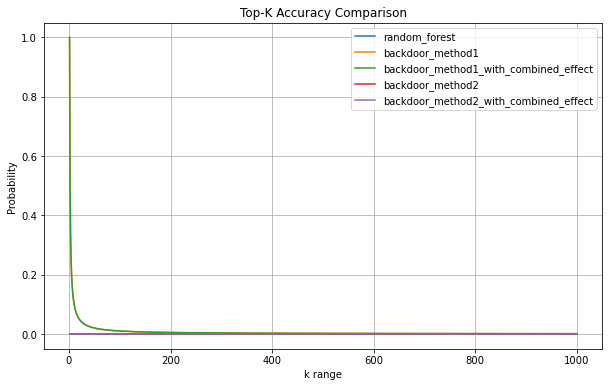

In [67]:
plt.figure(figsize=(10, 6))
for column in df_top_k_accuracy.columns[:-1]:
    plt.plot(df_top_k_accuracy["k_range"], df_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/top_k_comparison_german.png')

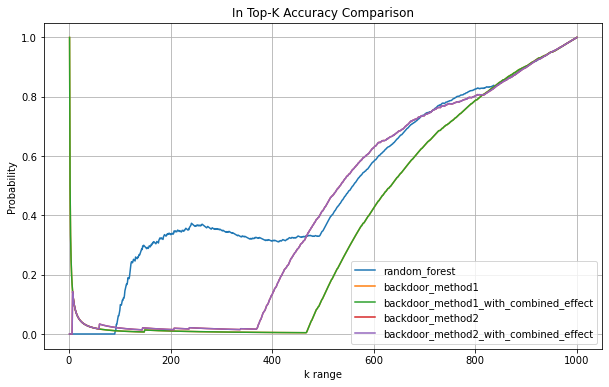

In [68]:
plt.figure(figsize=(10, 6))
for column in df_in_top_k_accuracy.columns[:-1]:
    plt.plot(df_in_top_k_accuracy["k_range"], df_in_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("In Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/In_top_k_comparison_german.png')
plt.show()

In [69]:
updated_df['true_row_index']=updated_df.index

In [70]:
rf_order['true_row_index']=rf_order.index

In [71]:
merged_df=backdoor_2_preds_cg.merge(updated_df,how='left', right_index=True,left_on='row_index')
merged_df['true_row_index']=merged_df.index

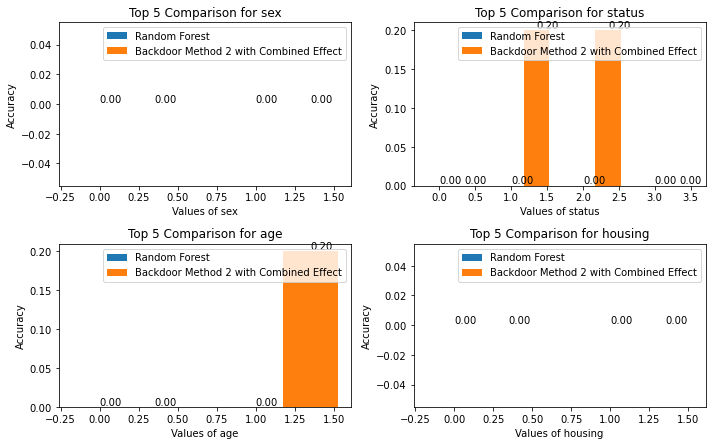

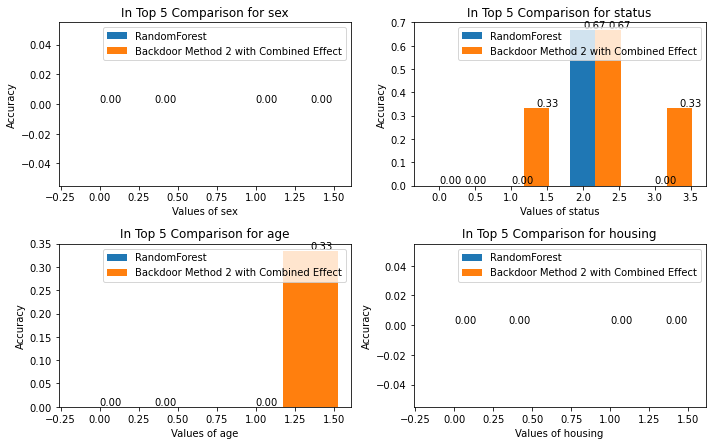

In [72]:
Xs =['sex', 'status', 'age', 'housing']


plt.figure(figsize=(10, 3 * len(Xs)))


for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    
    
    for i in true_row_indexes.index:
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        x_val.append(i)
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                      x:x_val})
    
    plt.subplot(4, 2, index)
    bar_width = 0.35
    r1 = np.arange(len(df_top_k_accuracy))
    r2 = [x + bar_width for x in r1]

    bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, label='Random Forest')
    bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'Top 5 Comparison for {x}')
    plt.legend()
    
plt.tight_layout()
plt.savefig('ranking_plots/top_5_comparison_all_features_German.png')
plt.show()



plt.figure(figsize=(10, 3 * len(Xs)))

# Iterate for In Top 5 Comparison plots
for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    
    
    for i in true_row_indexes.index:
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:3],true_row_indexes[i][0:3]))
        
        x_val.append(i)
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                      x:x_val})
    plt.subplot(4, 2, index)
    bar_width = 0.35
    r1 = np.arange(len(df_in_top_k_accuracy))
    r2 = [x + bar_width for x in r1]

    bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, label='RandomForest')
    bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'In Top 5 Comparison for {x}')
    plt.legend()

plt.tight_layout()
plt.savefig('ranking_plots/in_top_5_comparison_all_features_German.png')
plt.show()

In [73]:
df.head()

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
0,0,1.0,1,1,0,1,4.0,4.0,1.0,1,...,4.0,0.0,0.0,4.0,1.0,1.0,0,0.0,2.0,2
1,3,0.0,0,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.0,2.0,0
2,1,1.0,1,1,1,0,3.0,5.0,1.0,1,...,4.0,0.0,0.0,2.0,2.0,0.0,0,3.0,0.0,0
3,3,1.0,1,1,3,0,3.0,3.0,1.0,0,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.0,2.0,0
4,2,1.0,0,1,2,1,2.0,2.0,1.0,0,...,3.0,3.0,0.0,3.0,2.0,0.0,0,0.0,2.0,0


In [78]:
def k_range_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes,end_k):
    back_result=[]
    back2_result = []
    for z in range(k,end_k+1):
        updated_df=ranking_funcs.get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
        theta=updated_df[target_column].iloc[z-1]
        back_result.append(ranking_funcs.get_prob_backdoor_opt(G, df, z, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
        back2_result.append(ranking_funcs.get_prob_backdoor_opt2(G, df, k, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
    return back_result,back2_result

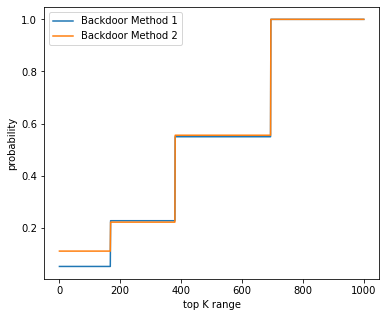

In [81]:
#The tupple 1
k_range_backdoor_val,k_range_backdoor2_val=ranking_funcs.k_range_backdoor(new_G, df, 1, {'status':2}, 'credit_amount', {'property':0}, 'fix', [1],len(df))
x_values = range(1, len(df)+1)    
plt.figure(figsize=(6, 5))
plt.plot(x_values, k_range_backdoor_val, label='Backdoor Method 1')
plt.plot(x_values, k_range_backdoor2_val, label='Backdoor Method 2')
plt.xlabel('top K range')
plt.ylabel('probability')
plt.legend()

plt.savefig(f'ranking_plots/topk_range_backdoor_german.png')
plt.show()

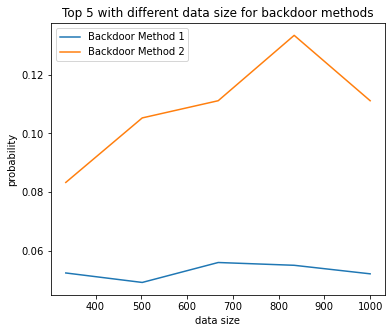

In [82]:
lenth,data_size_backdoor_val,data_size_backdoor2_val=ranking_funcs.data_size_backdoor(new_G, df, 3, {'status':2}, 'credit_amount', {'property':0}, 'fix', [1],6,123)
plt.figure(figsize=(6, 5))
plt.plot(lenth, data_size_backdoor_val, label='Backdoor Method 1')
plt.xlabel('data size')
plt.ylabel('probability')

plt.plot(lenth, data_size_backdoor2_val, label='Backdoor Method 2')
plt.xlabel('data size')
plt.ylabel('probability')
plt.title(f'Top 5 with different data size for backdoor methods')
plt.legend()

plt.savefig(f'ranking_plots/topk_backdoor_range_german.png')
plt.show()

In [83]:
var=['status']
df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df, 5, 'credit_amount',var,0, {'property':0},100, "add",2)
df_gr

,rank,prob,total_iters
0,"[714, 131, 784, 411, 268]",1.0,100.0


In [84]:
row_indexes=[714, 131, 784, 411, 268]
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 5, 'credit_amount',var,1, {'property':0} ,100, "add",2)

In [85]:
np.sum(greedy_backdoor)/100

0.00021961371964218041

In [86]:
np.sum(greedy_backdoor2)/100

0.00041236406345777123

In [87]:
baseline_val=ranking_funcs.base_line(df,5)**5
baseline_val

1.0513501203566246e-75

In [88]:
row_indexes=[714, 131, 784, 411, 268]
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G, df, 5, 'credit_amount',var,1, {'property':0} ,100, "add",2)

In [89]:
np.sum(greedy_backdoor)/100

0.00021961371964218041

In [90]:
np.sum(greedy_backdoor2)/100

0.00041236406345777123

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_8715/2670195572.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)
/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_8715/2670195572.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)


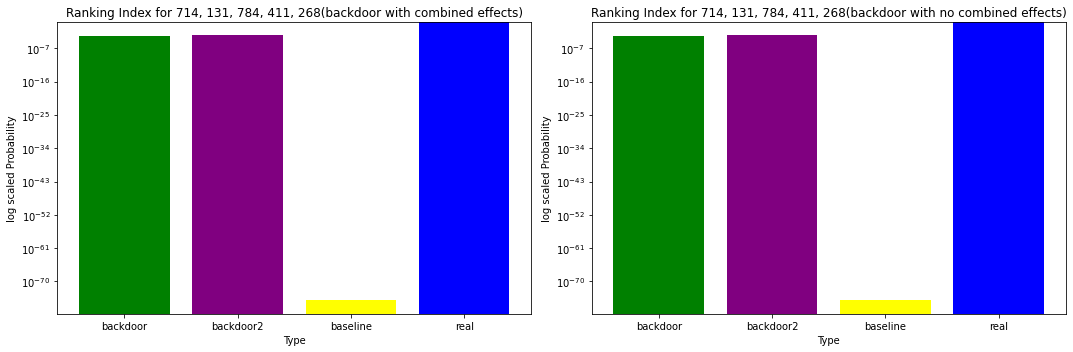

In [91]:
data1 = {'backdoor': 0.00021961371964218041,'backdoor2': 0.00041236406345777123, 'baseline':baseline_val,'real': 1}
data2 = {'backdoor': 0.00021961371964218041,'backdoor2': 0.00041236406345777123,  'baseline':baseline_val,'real': 1}

data=[data1, data2]

types = ['backdoor','backdoor2','baseline','real']
colors = {'backdoor': 'green', 'backdoor2':'purple','baseline': 'yellow','real': 'blue'}

titles = [
    "Ranking Index for 714, 131, 784, 411, 268(backdoor with combined effects)",
    "Ranking Index for 714, 131, 784, 411, 268(backdoor with no combined effects)"
]


fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

for i, d in enumerate(data):
    axes[i].bar(types, [d[t] for t in types], color=[colors[t] for t in types])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Type')
    axes[i].set_xticks(types)
    axes[i].set_ylabel('log scaled Probability')
    axes[i].set_yscale('log')
    max_val = max(d.values())
    axes[i].set_ylim(0, max_val)  

plt.tight_layout()
plt.savefig(f'ranking_plots/greedy_cgs_german.png')
plt.show()

In [92]:
import time

In [100]:
df_subsets=df.head(50)
iter_times=[10,50,100,150,200,250,300,350]
var=['status']
time_greedy_algo=[]

for i in iter_times:
    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df, 5, 'credit_amount',var,0, {'property':0},i, "add",2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)

In [101]:
time_greedy_backdoor=[]
row_indexes=[0, 1, 2, 7, 8]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G_combined, df, 5, 'credit_amount',var,0, {'property':0},i, "add",2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)

In [97]:
def Comp_Greedy_Algo_backdoor2(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    prob_result2=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result2

In [102]:
time_greedy_backdoor2=[]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G_combined, df, 5, 'credit_amount',var,0, {'property':0},i, "add",2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)

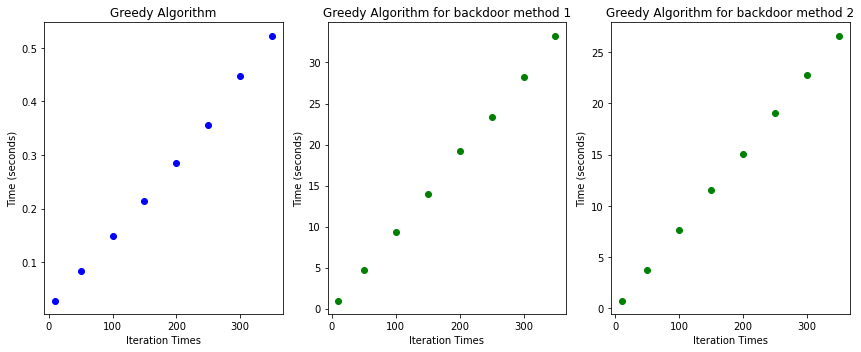

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

axes[0].scatter(x=iter_times, y=time_greedy_algo, color='blue')
axes[0].set_title('Greedy Algorithm')
axes[0].set_xlabel('Iteration Times')
axes[0].set_ylabel('Time (seconds)')

axes[1].scatter(x=iter_times, y=time_greedy_backdoor, color='green')
axes[1].set_title('Greedy Algorithm for backdoor method 1')
axes[1].set_xlabel('Iteration Times')
axes[1].set_ylabel('Time (seconds)')

axes[2].scatter(x=iter_times, y=time_greedy_backdoor2, color='green')
axes[2].set_title('Greedy Algorithm for backdoor method 2')
axes[2].set_xlabel('Iteration Times')
axes[2].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.savefig(f'ranking_plots/time_comparision_greedy_german.png')
plt.show()

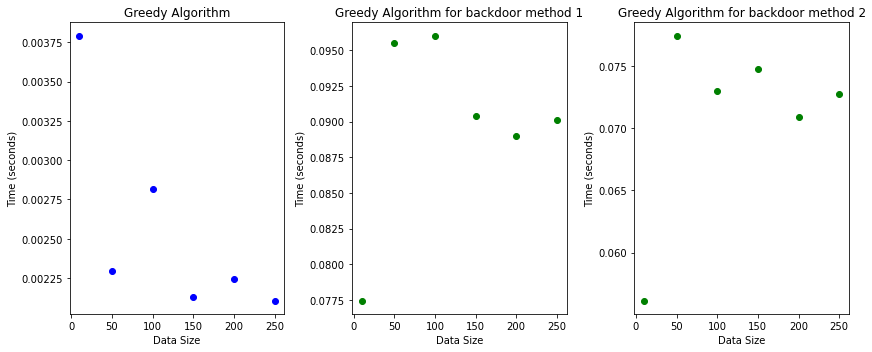

In [104]:
i_range=[10,50,100,150,200,250]
time_greedy_algo=[]
time_greedy_backdoor=[]
time_greedy_backdoor2=[]
df_rows=df.loc[row_indexes]
df_dropped = df.copy().drop(row_indexes)

for i in i_range:
    df_subsets=pd.concat([df_dropped.sample(i-5),df_rows])

    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G, df_subsets, 5, 'credit_amount',var,0, {'property':0},1, "add",2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G, df_subsets, 5, 'credit_amount',var,1, {'property':0} ,1, "add",2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G, df_subsets, 5, 'credit_amount',var,1, {'property':0} ,1, "add",2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)
    
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

axes[0].scatter(x=i_range, y=time_greedy_algo, color='blue')
axes[0].set_title('Greedy Algorithm')
axes[0].set_xlabel('Data Size')
axes[0].set_ylabel('Time (seconds)')

axes[1].scatter(x=i_range, y=time_greedy_backdoor, color='green')
axes[1].set_title('Greedy Algorithm for backdoor method 1')
axes[1].set_xlabel('Data Size')
axes[1].set_ylabel('Time (seconds)')

axes[2].scatter(x=i_range, y=time_greedy_backdoor2, color='green')
axes[2].set_title('Greedy Algorithm for backdoor method 2')
axes[2].set_xlabel('Data Size')
axes[2].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.savefig(f'ranking_plots/time_comparision_data_german.png')
plt.show()

In [105]:
df

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
0,0,1.0,1,1,0,1,4.0,4.0,1.0,1,...,4.0,0.0,0.0,4.0,1.0,1.0,0,0.0,2.0,2
1,3,0.0,0,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.0,2.0,0
2,1,1.0,1,1,1,0,3.0,5.0,1.0,1,...,4.0,0.0,0.0,2.0,2.0,0.0,0,3.0,0.0,0
3,3,1.0,1,1,3,0,3.0,3.0,1.0,0,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.0,2.0,0
4,2,1.0,0,1,2,1,2.0,2.0,1.0,0,...,3.0,3.0,0.0,3.0,2.0,0.0,0,0.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1.0,1,1,1,0,3.0,3.0,0.0,1,...,2.0,0.0,0.0,3.0,1.0,0.0,0,3.0,0.0,0
996,3,1.0,1,1,2,0,2.0,2.0,1.0,1,...,2.0,1.0,0.0,4.0,1.0,1.0,0,0.0,3.0,0
997,1,1.0,1,1,0,0,4.0,4.0,1.0,1,...,2.0,2.0,0.0,4.0,1.0,0.0,0,3.0,2.0,0
998,3,0.0,0,1,1,0,2.0,4.0,1.0,0,...,2.0,3.0,0.0,4.0,1.0,1.0,0,0.0,2.0,0


In [113]:
df_subsets=df.sample(50)

In [124]:
ranking_funcs.ranking_query_prob(new_G, df_subsets, 3, {'status':10}, 'credit_amount',{'property':0})

,row_index,1,2,3
868,868.0,0.000000,0.000000,0.000000
115,115.0,0.000000,0.000000,0.000000
201,201.0,0.000000,0.000000,0.000000
51,51.0,0.000000,0.000000,0.000000
72,72.0,0.000000,0.000000,0.000000
490,490.0,0.000000,0.000000,0.000000
624,624.0,0.000000,0.000000,0.000000
378,378.0,0.000000,0.000000,0.000000
609,609.0,0.000000,0.000000,0.000000
133,133.0,0.000000,0.000000,0.000000


In [119]:
df_subsets.head(3)

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
868,3,1.0,1,1,3,1,4.0,5.0,1.0,1,...,2.0,1.0,0.0,3.0,1.0,0.0,0,3.0,2.0,2
115,3,1.0,1,1,2,0,4.0,4.0,1.0,1,...,4.0,0.0,0.0,4.0,1.0,1.0,0,3.0,2.0,2
201,1,1.0,1,1,0,0,2.0,2.0,1.0,1,...,2.0,0.0,0.0,4.0,1.0,0.0,0,0.0,0.0,0


In [121]:
ranking_funcs.get_ranking_query_prob(new_G, df_subsets, 3, {'status':10}, 'credit_amount',{'property':0},'add')

,row_index,1,2,3
868,868.0,0.000000,0.000000,0.000000
115,115.0,0.000000,0.000000,0.000000
201,201.0,0.000000,0.000000,0.000000
51,51.0,0.000000,0.000000,0.000000
72,72.0,0.000000,0.000000,0.000000
490,490.0,0.000000,0.000000,0.000000
624,624.0,0.000000,0.000000,0.000000
378,378.0,0.000000,0.000000,0.000000
609,609.0,0.000000,0.000000,0.000000
133,133.0,0.000000,0.000000,0.000000


In [118]:
for i in range(10):
    tok_k_prob_df = ranking_funcs.get_ranking_query_prob(new_G, df_subsets, 3, {'status':i}, 'credit_amount',{'property':0},'fix')
    top3_ranking_probs = ranking_funcs.filter_prob_df(tok_k_prob_df)
    print(i)
    print('---------------')
    for idx in [868, 115, 201]:
        if idx in top3_ranking_probs.index:
            print(top3_ranking_probs.loc[idx])
        else:
            print(f"Index {idx} not found.")

0
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
1
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
2
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
3
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
4
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
5
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
6
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
7
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
8
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.
9
---------------
Index 868 not found.
Index 115 not found.
Index 201 not found.


In [129]:
for i in range(10):
    tok_k_prob_df = ranking_funcs.get_ranking_query_prob(new_G, df, 3, {'status':i}, 'credit_amount',{'property':0},'fix')
    top3_ranking_probs = ranking_funcs.filter_prob_df(tok_k_prob_df)
    print(i)
    print('---------------')
    for idx in [1, 3, 5]:
        if idx in top3_ranking_probs.index:
            print(top3_ranking_probs.loc[idx])
        else:
            print(f"Index {idx} not found.")

0
---------------
row_index    1.000000
1            0.005952
2            0.005952
3            0.005952
Name: 1, dtype: float64
row_index    3.000000
1            0.005952
2            0.005952
3            0.005952
Name: 3, dtype: float64
row_index    5.000000
1            0.005952
2            0.005952
3            0.005952
Name: 5, dtype: float64
1
---------------
row_index    1.000000
1            0.005952
2            0.005952
3            0.005952
Name: 1, dtype: float64
row_index    3.000000
1            0.005952
2            0.005952
3            0.005952
Name: 3, dtype: float64
row_index    5.000000
1            0.005952
2            0.005952
3            0.005952
Name: 5, dtype: float64
2
---------------
row_index    1.000000
1            0.005952
2            0.005952
3            0.005952
Name: 1, dtype: float64
row_index    3.000000
1            0.005952
2            0.005952
3            0.005952
Name: 3, dtype: float64
row_index    5.000000
1            0.005952
2     

In [125]:
0.005952*0.005952*0.005952

2.10857361408e-07

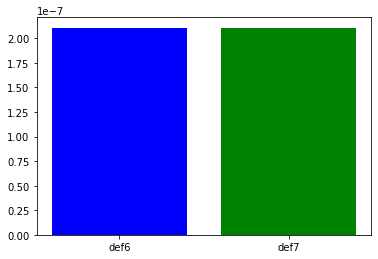

In [130]:
data = {'def6': 2.10857361408e-07, 'def7': 2.10857361408e-07}

labels = list(data.keys())
heights = list(data.values())

colors = ['blue', 'green']  


plt.bar(labels, heights, color=colors)

plt.savefig(f'ranking_plots/two_def_german.png')
plt.show()